In [3]:
#import all libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imutils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 1.14.0


In [4]:
for expression in os.listdir("C:\\Users\\user\\Desktop\\Project\\train"):
    print(str(len(os.listdir("C:\\Users\\user\\Desktop\\Project\\train\\" + expression))) + " " + expression + " images")

3995 angry images
436 disgust images
4097 fear images
7214 happy images
4965 neutral images
4830 sad images
3171 surprise images


In [8]:
img_size = 25
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("C:\\Users\\user\\Desktop\\Project\\train\\",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("C:\\Users\\user\\Desktop\\Project\\test\\",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(25, ,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 25, 25, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 25, 25, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 25, 25, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 128)       204928    
_________________________________________________________________
batch_normalization_13 (Batc (None, 12, 12, 128)      

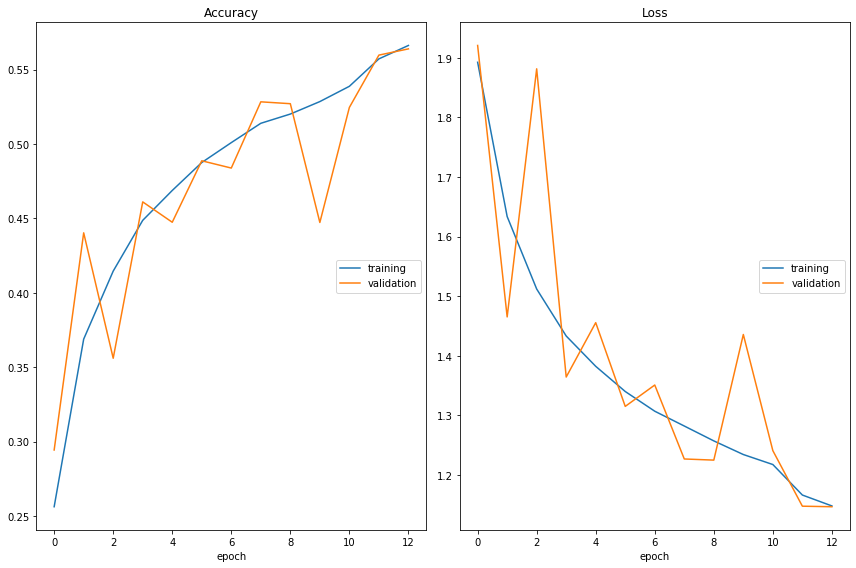

Accuracy
	training         	 (min:    0.256, max:    0.566, cur:    0.566)
	validation       	 (min:    0.294, max:    0.564, cur:    0.564)
Loss
	training         	 (min:    1.148, max:    1.892, cur:    1.148)
	validation       	 (min:    1.147, max:    1.921, cur:    1.147)

Epoch 00013: saving model to model_weights.h5
448/448 [==============================] - 387s 863ms/step - loss: 1.1483 - acc: 0.5662 - val_loss: 1.1468 - val_acc: 0.5639
Wall time: 1h 29min 31s


In [12]:
%%time

epochs = 20
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [14]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [3]:
from tensorflow.keras.models import model_from_json

import numpy as np

import tensorflow as tf




class FacialExpressionModel(object):

    EMOTIONS_LIST = ["Angry", "Disgust",
                     "Fear", "Happy",
                     "Neutral", "Sad",
                     "Surprise"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        #self.loaded_model.compile()
        #self.loaded_model._make_predict_function()

    def predict_emotion(self, img):
        
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]

In [5]:
import cv2

import numpy as np

facec = cv2.CascadeClassifier('C:\\Users\\user\\anaconda3\\Lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model.json", "model_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX
video_capture = cv2.VideoCapture(0)

while True:
    
    # returns camera frames along with bounding boxes and predictions
    ret, frame = video_capture.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

       
    faces = facec.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
            fc = gray[y:y+h, x:x+w]

            roi = cv2.resize(fc, (25, 25))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])

            cv2.putText(frame, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)

            cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()